## Import packages

In [487]:
import networkx as nx
import numpy as np
import cvxpy as cp
import scipy.io
import matplotlib.pyplot as plt
from itertools import product
import copy
import itertools

## Functions and constants

In [488]:
options = {
    "font_size": 10,
    "node_size": 500,
    "node_color": "white",
    "edgecolors": "black",
    "linewidths": 1,
    "width": 1,
    "font_family":"monospace"
}

In [489]:
#format a dict to make it more readable
def format_dict(dictionary):
    l_type = type(list(list(dictionary.values())[0].values())[0])
    if l_type not in [int, np.float64]:
        ed = {(k, k2): v2['capacity'] for k,v in dictionary.items() for k2,v2 in v.items()}
    else:
        ed = {(k,k2): int(v2) for k,v in dictionary.items() for k2,v2 in v.items()}
    return ed

def format_dict_spec(dictionary):
    l_type = type(list(list(dictionary.values())[0].values())[0])
    if l_type not in [int, np.float64]:
        ed = {(k, k2): v2['capacity'] for k,v in dictionary.items() for k2,v2 in v.items()}
    else:
        ed = {(k,k2): int(v2) for k,v in dictionary.items() for k2,v2 in v.items()}
    return ed


In [490]:
def add_capacity(G, edges, capacity):
    #g = copy.deepcopy(G)
    g = nx.DiGraph(G)
    if isinstance(capacity, int) or isinstance(capacity, float):
        for e in edges:
            #print(e)
            g.edges.__getitem__(list(e))['capacity'] += capacity
    elif isinstance(capacity, list):
        for i,e in enumerate(edges):
            g.edges.__getitem__(list(e))['capacity'] += capacity[i]
    else:
        raise ValueError("type capacity wrong")
    return g


In [491]:
#set the capacities on a graph passing the vector C
def set_capacities(G, c):
    for i,edge in enumerate(G.edges):
        G[edge[0]][edge[1]]['capacity'] = c[i]


In [492]:
#return the edge list from a node-link incidence matrix
def from_incidence(B):
    edge_list = []
    for j in range(B.shape[1]):
        for i in range(B.shape[0]):
            if B[i][j] > 0:
                head = i+1
            if B[i][j] < 0:
                edge_list.append((head, i+1))

    return edge_list


In [493]:
#compute the color list respect to edges with flow
def get_color_list(edges, Graph, flow):
    color = ['red' if f==1 else 'black' for f in flow ]
    color_list = []

    for i,e in enumerate(edges):
        Graph.edges.__getitem__(list(e))['color'] = color[i]

    for i,e in enumerate(Graph.edges):
        color_list.append(Graph.edges.__getitem__(list(e))['color'])
    
    return color_list

In [494]:
#define function for cost of Wardrop
def cost(f):
    return sum(f*l/(1-f/C))

In [495]:
def cuts(Gr, s, t):
    g = nx.Graph(Gr).to_undirected()
    b= []
    for r in range(1, len(G.nodes)):
        b+= list(filter(lambda x : s in  x  and t not in x , itertools.combinations(list(g.nodes()),r)))
    cuts_list = [(set(s), set(g.nodes()) ^ set(s)) for s in b]
    return cuts_list

In [496]:
def min_cuts(G, s, t):
    cu = np.array(cuts(G, s, t))
    cut_capacity = [nx.cut_size(G, k[0], k[1], 'capacity') for k in cu]
    cut_capacity = np.array(cut_capacity)
    m_cuts = cu[np.where(cut_capacity == min(cut_capacity))[0]]
    return m_cuts.tolist()

In [497]:
from itertools import product
def edge_mincuts_intersection(G, s, t):
    min_cuts_list = min_cuts(G, s, t)
    edges_list = []
    for mcp in min_cuts_list:
        edges_cut = list(product(list(mcp[0]), list(mcp[1])))
        edge = list(filter(lambda x : x in G.edges, product(list(mcp[0]), list(mcp[1]))))
        edges_list.append(set(edge))
    intersection = set.intersection(*edges_list)
    if intersection:
        return set.intersection(*edges_list).pop()
    #if the intersection is empty search for the edge more present in the min cuts partitions
    #list of all edges in the partitions of min cuts
    ed = sum([list(eg) for eg in edges_list], [])
    ed = np.array(ed)
    #counts edges presence
    counts_edges = np.array([np.all(ed == el, axis=1).sum() for el in ed])
    #find edge
    indx = np.where(counts_edges == max(counts_edges))[0][0]
    return ed[indx].tolist()

In [498]:
from itertools import product
import copy
def function_capacity_troughput(Gi, max_cap):
    Gr = nx.DiGraph(Gi)
    max_f, f = nx.algorithms.flow.maximum_flow(Gr,"o","d")
    max_troughput = []
    max_troughput.append(max_f)
    for c in range(max_cap):
        edge = edge_mincuts_intersection(Gr, "o", "d")
        Gr = add_capacity(Gr, [edge], 1)
        max_f, f = nx.algorithms.flow.maximum_flow(Gr,"o","d")
        max_troughput.append(max_f)
    return max_troughput

## Exercise 1

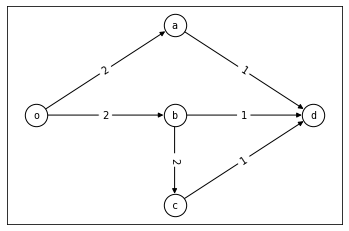

In [499]:
G = nx.DiGraph()
edges = [('o','a'), ('o', 'b'), ('a','d'), ('b', 'c'), ('b', 'd'), ('c','d')]
pos = {'o':(0,1), 'a':(1,2), 'b':(1,1), 'c':(1,0), 'd':(2,1)}
cap = [2,2,1,2,1,1]
G.add_edges_from(edges)
set_capacities(G,cap)
ed = format_dict(G.edges._adjdict)

nx.draw_networkx(G, pos, **options)
nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=ed)
plt.savefig('plot1gen', dpi=120)
plt.show()

***1.a***

In [500]:
max_flow, set_1 = nx.maximum_flow(G, 'o', 'd')
format_dict(set_1)

{('o', 'a'): 1,
 ('o', 'b'): 2,
 ('a', 'd'): 1,
 ('b', 'c'): 1,
 ('b', 'd'): 1,
 ('c', 'd'): 1}

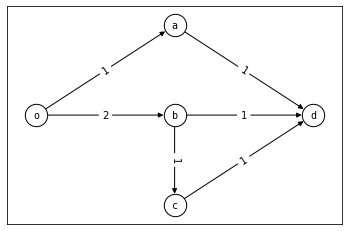

In [501]:
elab = {k:int(v) for k,v in format_dict(set_1).items() if v>0}
nx.draw_networkx(G, pos, **options)
nx.draw_networkx_edge_labels(G, pos, edge_labels=elab)
plt.savefig('plot1a', dpi=120)
plt.show()

***Cuts***

The min-cut is 3, so we can say that the minimal capacity to remove to make infeasable the flow is 3

- $U: \{o\}$ ; $U^c: \{a,b,c,d\}$ -> $C_u = 4$
- $U: \{o,a\}$ ; $U^c: \{b,c,d\}$ -> $C_u = 3$
- $U: \{o,b\}$ ; $U^c: \{a,c,d\}$ -> $C_u = 5$
- $U: \{o,a,b\}$ ; $U^c: \{c,d\}$ -> $C_u = 4$
- $U: \{o,a,b,c\}$ ; $U^c: \{d\}$ -> $C_u = 3$

***1.b***

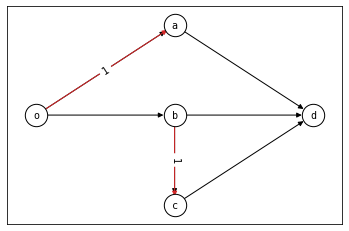

In [502]:
#to define
f_set_a = format_dict(set_1)
f_set_cap = format_dict_spec(G.edges._adjdict)
res = {key: f_set_cap[key] - f_set_a.get(key, 0)
                       for key in f_set_cap.keys()}
res
el = [k for k,v in res.items() if v == 1]
res2 = {k:int(v) for k,v in res.items() if v == 1}
nx.draw_networkx(G, pos, **options)
nx.draw_networkx_edges(G, pos, edgelist=el, edge_color='tab:red')
nx.draw_networkx_edge_labels(G, pos, edge_labels=res2)
plt.savefig('plot1b', dpi=120)
plt.show()


The links $(o,a)$ and $(b,c)$ are both with 1 capacity left, so the max capacity we can remove without affecting the flow is 2.

***1.c***

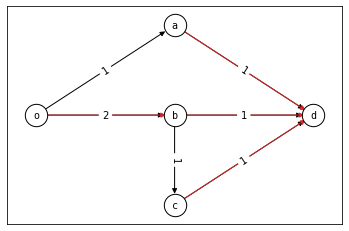

In [503]:
#to define
f_set_a = format_dict(set_1)
f_set_cap = format_dict_spec(G.edges._adjdict)
res = {key: f_set_cap[key] - f_set_a.get(key, 0)
                       for key in f_set_cap.keys()}
res
el = [k for k,v in res.items() if v == 0]
res2 = {k:int(v) for k,v in res.items() if v == 0}
nx.draw_networkx(G, pos, **options)
nx.draw_networkx_edges(G, pos, edgelist=el, edge_color='tab:red')
nx.draw_networkx_edge_labels(G, pos, edge_labels=f_set_a)
plt.savefig('plot1b_saturated', dpi=120)
plt.show()

Considering the cuts, we choose the Cuts with min capacity
- $U: \{o,a\}$ ; $U^c: \{b,c,d\}$ -> $C_u = 3$
- $U: \{o,a,b,c\}$ ; $U^c: \{d\}$ -> $C_u = 3$

With respective links:

- $U: \{o,a\}$ -> $C_u = (o,b) + (a,d)$
- $U: \{o,a,b,c\}$ -> $C_u = (a,d) + (b,d) + (c,d)$

We can see that $(a,d)$ is a common link, so we put the additional capacity.

We recompute the min-cuts:

- $U: \{o\}$ ; $U^c: \{a,b,c,d\}$ -> $C_u = 4$
- $U: \{o,a\}$ ; $U^c: \{b,c,d\}$ -> $C_u = 4$
- $U: \{o,b\}$ ; $U^c: \{a,c,d\}$ -> $C_u = 5$
- $U: \{o,a,b\}$ ; $U^c: \{c,d\}$ -> $C_u = 4$
- $U: \{o,a,b,c\}$ ; $U^c: \{d\}$ -> $C_u = 4$


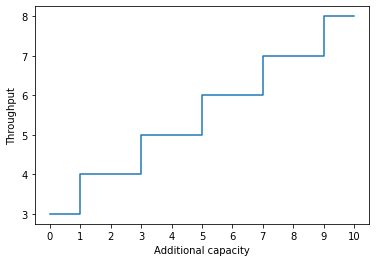

In [504]:
x = np.arange(11)
y= function_capacity_troughput(G, 10)
fig, ax = plt.subplots()
ax.step(x,y, where='post')
plt.xticks(x)
plt.xlabel('Additional capacity')
plt.ylabel('Throughput')
plt.savefig('plot1c_throughput_functon', dpi=120)
plt.show()

## Exercise 2

***Perfect Matching***

As we know from Hall's Theorem, a perfect matching exists if and only if |$V_0$| < |$V_1$|, where $V_0$ is the number of nodes in the first partition and $V_1$ the number of nodes in the second partition. Moreover, the condition $ |\mathcal{S}| \le |\mathcal{N_\mathcal{S}}|  $ with $ \forall \mathcal{S} \subset V_0 $ must be satisfied.

***2.a***

We can exploit if there exists a perfect matching using max-flow min-cut theorem and adding a source node $o$ and a sink node $d$. Then we create links from $o$ to every source node of the Graph and from every sink a link to $d$.

All links have capacity 1.

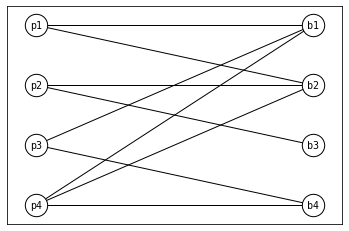

In [505]:
G2 = nx.Graph()
edge_l = [('p1','b1'), ('p1','b2'), ('p2', 'b2'), ('p2','b3'),('p3','b1'), ('p3','b4'), ('p4','b1'),('p4','b2'),('p4','b4')]
pos = {'p1':(0,3), 'p2':(0,2), 'p3':(0,1), 'p4':(0,0), 'b1':(1,3),'b2':(1,2),'b3':(1,1),'b4':(1,0)}
G2.add_edges_from(edge_l)
nx.draw_networkx(G2, pos=pos, **options)
plt.savefig('plot2gen', dpi=120)
plt.show()


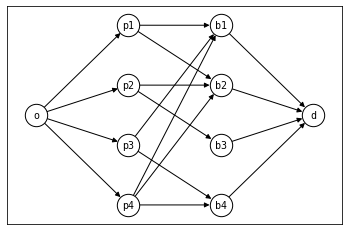

In [506]:
o_edges = [('o','p1'), ('o','p2'), ('o','p3'),('o','p4')]
d_edges = [('b1','d'),('b2','d'),('b3','d'),('b4','d')]
G2_new = nx.DiGraph()
G2_new.add_edges_from(o_edges)
G2_new.add_edges_from(d_edges)
G2_new.add_edges_from(edge_l)
pos2 = pos
pos2['o'] = (-1,1.5)
pos2['d'] = (2, 1.5)
nx.draw_networkx(G2_new, pos=pos2, **options)
#nx.draw_networkx_edges(G2_new, pos=pos2, edgelist=[('p1','b1')], edge_color='tab:red', width=3)
plt.savefig('plot2a', dpi=120)
plt.show()

4.0


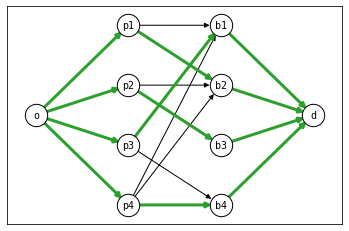

In [507]:
capacities = np.ones(len(G2_new.edges))
set_capacities(G2_new,capacities)
max_flow, set_a = nx.maximum_flow(G2_new, 'o', 'd')
print(max_flow)
f_a = format_dict(set_a)
elist = [k for k,v in f_a.items() if v > 0]
nx.draw_networkx(G2_new, pos=pos2, **options)
nx.draw_networkx_edges(G2_new, pos2, edgelist=elist,edge_color='tab:green', width=3)
#plt.tight_layout()
#plt.axis("off")
plt.savefig('plot2a_flow', dpi=120)
plt.show()


We can see that the maximum flow is equal to |$V_0|$, this let us know that a perfect matching for $V_0$ exists.

***1.b***

When we add books' copies, we assume that the outgoing capacities through $d$ are, respectively, $\quad (2,3,2,2)$

We add an infinite capacity on edges from the origin $o$ because the number of books for people is arbitrary. 

We found the maximum flow is now 8, that is the number of possible matchings.

In [508]:
G2_new['b1']['d']['capacity'] = 2
G2_new['b2']['d']['capacity'] = 3
G2_new['b3']['d']['capacity'] = 2
G2_new['b4']['d']['capacity'] = 2
G2_new['o']['p1']['capacity'] = float('inf')
G2_new['o']['p2']['capacity'] = float('inf')
G2_new['o']['p3']['capacity'] = float('inf')
G2_new['o']['p4']['capacity'] = float('inf')
max_flow, set_a = nx.maximum_flow(G2_new, 'o', 'd')
print(max_flow)

8.0


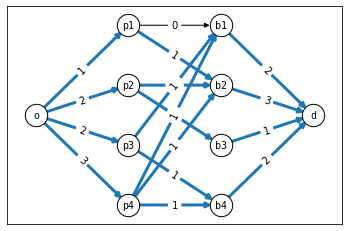

In [509]:
el = [k for k,v in format_dict(set_a).items() if v > 0]
nx.draw_networkx(G2_new, pos2, **options)
nx.draw_networkx_edges(G2_new, pos2, width=3, edgelist=el, edge_color='tab:blue')
nx.draw_networkx_edge_labels(G2_new, pos2, edge_labels=format_dict(set_a), font_color='black')
plt.savefig('plot2b_capacity', dpi=120)
plt.show()
#flow sui libri assegnati

***1.c***

To maximize the sells, we have to find out which book is not sold out. 

Using $nx.mininum\_cut$ we can see that $b3$ is not included in the cut, so this book is not sold out.

In [510]:
nx.minimum_cut(G2_new, 'o', 'd')

(8.0, ({'b1', 'b2', 'b4', 'o', 'p1', 'p2', 'p3', 'p4'}, {'b3', 'd'}))

Now we have to find out book to swap with $b3$ computing the difference between edges' flow and edges' capacity

In [511]:
f_set_a = format_dict(set_a)
f_set_cap = format_dict_spec(G2_new.edges._adjdict)
res = {key: f_set_cap[key] - f_set_a.get(key, 0)
                       for key in f_set_cap.keys()}
res

{('o', 'p1'): inf,
 ('o', 'p2'): inf,
 ('o', 'p3'): inf,
 ('o', 'p4'): inf,
 ('p1', 'b1'): 1.0,
 ('p1', 'b2'): 0.0,
 ('p2', 'b2'): 0.0,
 ('p2', 'b3'): 0.0,
 ('p3', 'b1'): 0.0,
 ('p3', 'b4'): 0.0,
 ('p4', 'b1'): 0.0,
 ('p4', 'b2'): 0.0,
 ('p4', 'b4'): 0.0,
 ('b1', 'd'): 0,
 ('b2', 'd'): 0,
 ('b3', 'd'): 1,
 ('b4', 'd'): 0}

[('p1', 'b1'), ('b3', 'd')]


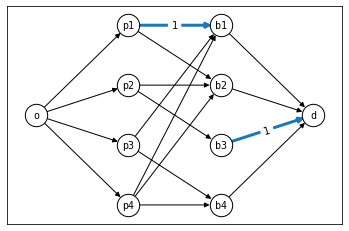

In [512]:
el = [k for k,v in res.items() if v == 1]
res2 = {k:int(v) for k,v in res.items() if v == 1}
print(el)
nx.draw_networkx(G2_new, pos2, **options)
nx.draw_networkx_edges(G2_new, pos2, width=3, edgelist=el, edge_color='tab:blue')
nx.draw_networkx_edge_labels(G2_new, pos2, edge_labels=res2, font_color='black')
plt.savefig('plot2c_residual_cap', dpi=120)
plt.show()
#libri ancora disponibili e richiesti

The edge $p1$ -> $b1$ has 1 capacity left, so we can optimize changing the book $b3$ with $b1$.

We compute a graph for proof this:

9.0
False


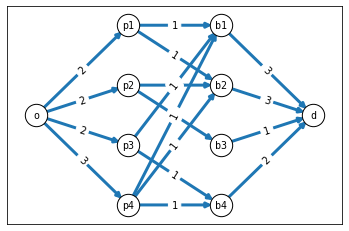

In [513]:
G2_bis = G2_new
G2_bis['b1']['d']['capacity'] = 3
G2_bis['b2']['d']['capacity'] = 3
G2_bis['b3']['d']['capacity'] = 1
G2_bis['b4']['d']['capacity'] = 2
mf, new_set = nx.maximum_flow(G2_bis, 'o', 'd')
print(mf)
print(set_a == new_set)
nx.draw_networkx(G2_new, pos2, **options)
el = [k for k,v in format_dict(new_set).items() if v > 0]
nx.draw_networkx_edges(G2_new, pos2, width=3, edgelist=el, edge_color='tab:blue')
nx.draw_networkx_edge_labels(G2_new, pos2, edge_labels=format_dict(new_set), font_color='black')
plt.savefig('plot2c_optimized_flow', dpi=120)
plt.show()
#nuovo flow sui libri dopo aver scambiato b3 e b1

## Exercise 3

In [514]:
import scipy.io
import cvxpy as cp

f = scipy.io.loadmat('flow.mat')["flow"].reshape(28,)
C = scipy.io.loadmat('capacities.mat')["capacities"].reshape(28,)
B = scipy.io.loadmat('traffic.mat')["traffic"]
l = scipy.io.loadmat('traveltime.mat')["traveltime"].reshape(28,)
# m = (np.dot(B, B.T)).astype(int)
# np.fill_diagonal(m,0)
# G3 = nx.from_numpy_matrix(m)
pos = {
    1: [0, 0],
    2: [4, 0],
    3: [6, 0],
    4: [10, 0],
    5: [14, -1],
    6: [1, -4],
    7: [4, -4],
    8: [6, -4],
    9: [8, -3],
    10: [4, -8],
    11: [6, -8],
    12: [8, -8],
    13: [12, -9],
    14: [14, -9],
    15: [6, -10],
    16: [9, -11],
    17: [14, -12]
 }


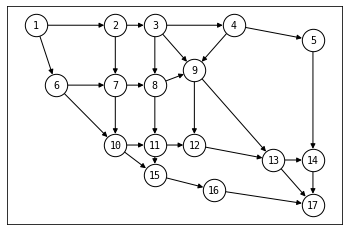

In [515]:
edges = from_incidence(B)
G3 = nx.DiGraph()
G3.add_edges_from(edges)
nx.draw_networkx(G3, pos, **options)
plt.savefig('plot3gen', dpi=120)
plt.show()

***Question a***

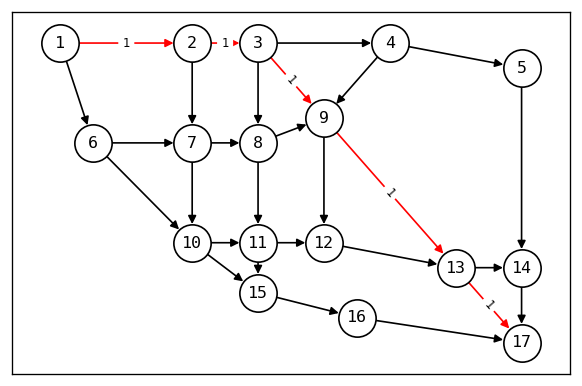

In [516]:
plt.figure(dpi=120)
n_edges = B.shape[1]
nu = np.zeros(B.shape[0])
nu[0] = 1
nu[-1] = -1
unit_flow = cp.Variable(n_edges)
objective = cp.Minimize(l.T @ unit_flow)
constraints = [B @ unit_flow == nu, unit_flow>=0]
prob = cp.Problem(objective, constraints)
flow_cost = prob.solve()
flow = np.isclose(unit_flow.value,1).astype(int)
unit_flow.value, flow_cost
color_list = get_color_list(edges, G3, flow)
elab = {k:int(v) for k,v in dict(zip(edges, flow)).items() if v == 1}
nx.draw_networkx(G3,pos, edge_color=color_list, **options)
nx.draw_networkx_edge_labels(G3,pos, edge_labels=elab, font_size=7)
plt.savefig('plot3a_unitary_flow', dpi=120) 
plt.show()

In [517]:
{k:int(v) for k,v in dict(zip(edges, flow)).items() if v == 1}

{(1, 2): 1, (2, 3): 1, (9, 13): 1, (3, 9): 1, (13, 17): 1}

***Question b***

{1: {2: 8741, 6: 9864}, 2: {3: 8741, 7: 0}, 3: {4: 1319, 8: 0, 9: 7422}, 4: {5: 1319, 9: 0}, 5: {14: 1319}, 6: {7: 894, 10: 8970}, 7: {8: 894, 10: 0}, 8: {9: 894, 11: 0}, 9: {13: 8316, 12: 0}, 13: {14: 590, 17: 10019}, 14: {17: 1909}, 10: {11: 2293, 15: 6677}, 11: {12: 2293, 15: 0}, 15: {16: 6677}, 12: {13: 2293}, 17: {}, 16: {17: 6677}}


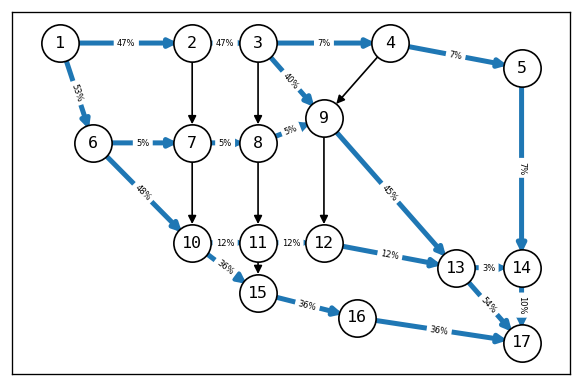

In [518]:
plt.figure(dpi=120)
set_capacities(G3,C)
max_f, set_f = nx.maximum_flow(G3, 1, 17)
print(set_f)
el = [(k,k2) for k,v in set_f.items() for k2,v2 in v.items() if v2 > 0]
elab = {(k,k2): f'{int(v2)*100/max_f:.0f}%' for k,v in set_f.items() for k2,v2 in v.items() if v2>0}
nx.draw_networkx(G3, pos, **options)
nx.draw_networkx_edges(G3, pos, width=3, edgelist=el, edge_color='tab:blue')
nx.draw_networkx_edge_labels(G3, pos, edge_labels=elab, font_color='black', font_size=5)
plt.savefig('plot3b_cap_percentage_mf', dpi=120)
plt.show()

***Question c***

In [520]:
nu = B@f
print(nu)
new_nu = np.zeros(len(nu))
new_nu[0] = nu[0]
new_nu[-1] = -nu[0]
nu = new_nu

[ 16806   8570  19448   4957   -746   4768    413     -2  -5671   1169
     -5  -7131   -380  -7412  -7810  -3430 -23544]


***Question d***

In [522]:
f_star = cp.Variable(n_edges)
fun = cp.multiply(cp.multiply(l,C), cp.inv_pos(1-cp.multiply(f_star,cp.inv_pos(C)))) - cp.multiply(l,C)
objective = cp.Minimize(
    cp.sum(fun)
)
constraints = [B@f_star == nu, f_star>=0]
prob = cp.Problem(objective, constraints)
opt_cos = prob.solve()
f_star.value, opt_cos

(array([6.64230051e+03, 6.05889802e+03, 3.13240161e+03, 3.13240145e+03,
        1.01636995e+04, 4.63840047e+03, 3.00636212e+03, 2.54258815e+03,
        3.13151936e+03, 5.83402485e+02, 1.26113499e-03, 2.92649515e+03,
        1.56756001e-04, 3.13240145e+03, 5.52529902e+03, 2.85430437e+03,
        4.88643549e+03, 2.21544084e+03, 4.63775232e+02, 2.33756409e+03,
        3.31807944e+03, 5.65564353e+03, 2.37304293e+03, 1.63316053e-04,
        6.41411997e+03, 5.50544438e+03, 4.88643565e+03, 4.88643565e+03]),
 25943.621934951483)

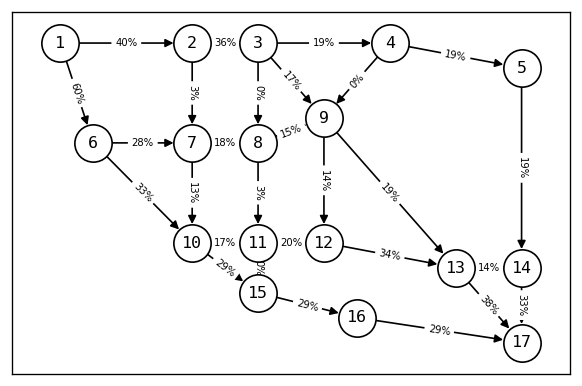

In [523]:
plt.figure(dpi = 120)
elab = dict(zip(edges, f_star.value*100/nu[0]))
elab = {k: f'{v:.0f}%' for k,v in elab.items()}
nx.draw_networkx(G3, pos, **options)
#nx.draw_networkx_edges(G3, pos, width=3, edgelist=el, edge_color='tab:blue')
nx.draw_networkx_edge_labels(G3, pos, edge_labels=elab, font_color='black', font_size=6)
plt.savefig('plot3d_soc_optimum', dpi=120)
plt.show()

***Question e***

In [525]:
f_war = cp.Variable(n_edges)
delay_func_integral  = cp.multiply(-cp.multiply(C, l), cp.log( 1 - cp.multiply(f_war, cp.inv_pos(C))))
objective = cp.Minimize(
    cp.sum(delay_func_integral)
)
constraints = [B@f_war == nu, f_war>=0]
prob = cp.Problem(objective, constraints)
war_eq = prob.solve()
f_war.value, war_eq

(array([6.71564829e+03, 6.71564741e+03, 2.36740739e+03, 2.36740731e+03,
        1.00903516e+04, 4.64539488e+03, 2.80384250e+03, 2.28356153e+03,
        3.41848000e+03, 8.78819518e-04, 1.76829148e+02, 4.17141087e+03,
        7.86356185e-05, 2.36740731e+03, 5.44495677e+03, 2.35317159e+03,
        4.93333843e+03, 1.84155326e+03, 6.97110115e+02, 3.03649247e+03,
        3.05028160e+03, 6.08677407e+03, 2.58651170e+03, 1.08862333e-04,
        6.91874238e+03, 4.95391901e+03, 4.93333854e+03, 4.93333854e+03]),
 15729.607069736616)

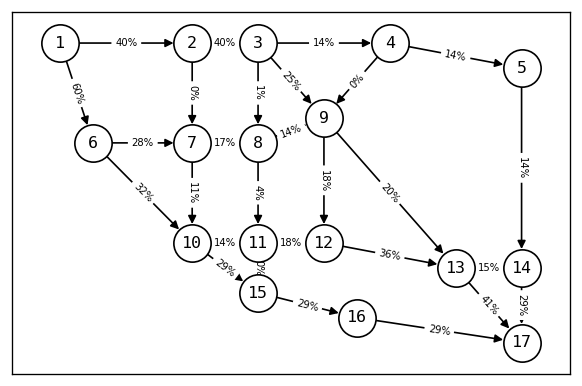

In [526]:
plt.figure(dpi = 120)
elab = dict(zip(edges, f_war.value*100/nu[0]))
elab = {k: f'{v:.0f}%' for k,v in elab.items()}
nx.draw_networkx(G3, pos, **options)
#nx.draw_networkx_edges(G3, pos, width=3, edgelist=el, edge_color='tab:blue')
nx.draw_networkx_edge_labels(G3, pos, edge_labels=elab, font_color='black', font_size=6)
plt.savefig('plot3e_war_eq', dpi=120)
plt.show()

But this is not the cost of wardrop equilibrium, so we compute that using

$\quad\sum f_{war}\tau_e(f_{war})$

In [527]:
cost_w = cost(f_war.value)
cost_w

26292.963732052354

The Price of Anarchy will be:

In [528]:
PoA = cost_w / opt_cos
f'{PoA:.4f}'

'1.0135'

***Question e: adding tolls***

We define toll to add on each link $\omega_e = f^* \tau_e'(f^*)$ where $f^*$ is the social optimum flow.

The new delay function will be $\tau_e(f_e) + \omega_e$

We can compute the new Wardrop equilibrium $f^{(\omega)}$

In [529]:
f_wt = cp.Variable(n_edges)
w = f_star.value * C*l /(C- f_star.value)**2        #C*l / (C- f_star)^2
new_delay = cp.multiply(-cp.multiply(C, l), cp.log( 1 - cp.multiply(f_wt, cp.inv_pos(C)))) + cp.multiply(f_wt, w)
objective = cp.Minimize(
    cp.sum(new_delay)
)
constraints = [B@f_wt==nu, f_wt>=0]
prob = cp.Problem(objective, constraints)
war_toll = prob.solve()

f_wt.value, war_toll


(array([6.64230468e+03, 6.05906999e+03, 3.13229874e+03, 3.13229865e+03,
        1.01636952e+04, 4.63801369e+03, 3.00624951e+03, 2.54244517e+03,
        3.13154097e+03, 5.83234693e+02, 3.45598819e-04, 2.92677090e+03,
        9.40191923e-05, 3.13229865e+03, 5.52568152e+03, 2.85425150e+03,
        4.88642889e+03, 2.21499887e+03, 4.63804687e+02, 2.33767519e+03,
        3.31805607e+03, 5.65573126e+03, 2.37316586e+03, 1.20959778e-04,
        6.41410637e+03, 5.50546451e+03, 4.88642901e+03, 4.88642901e+03]),
 61885.968260469526)

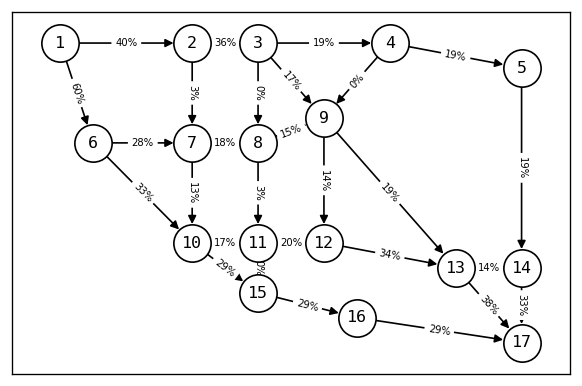

In [530]:
plt.figure(dpi = 120)
elab = dict(zip(edges, f_wt.value*100/nu[0]))
elab = {k: f'{v:.0f}%' for k,v in elab.items()}
nx.draw_networkx(G3, pos, **options)
#nx.draw_networkx_edges(G3, pos, width=3, edgelist=el, edge_color='tab:blue')
nx.draw_networkx_edge_labels(G3, pos, edge_labels=elab, font_color='black', font_size=6)
plt.savefig('plot3e_war_with_tolls', dpi=120)
plt.show()


As before, we compute the Wardrop cost

In [531]:
cost_wt = cost(f_wt.value)
cost_wt

25943.621463166437

We can see now the Price of Anarchy that has become 1

In [532]:
nPoA = cost_wt/opt_cos
nPoA

0.9999999818149892

New cost function:
$\quad \psi_e(f_e) = f_e(\tau_e(f_e) - l_e)$

where 
$$
\quad \tau_e(f_e) \quad = \quad\frac{l_e}{1-f_e / C_e}
$$

***3.f***

In [533]:
f_new = cp.Variable(n_edges)
new_cost_func = cp.multiply(cp.multiply(l,C), cp.inv_pos(1-cp.multiply(f_new,cp.inv_pos(C)))) - cp.multiply(l,C)
objective = cp.Minimize(
    cp.sum(new_cost_func - cp.multiply(f_new,l))
    )
constraints = [B@f_new==nu, f_new>=0]
prob = cp.Problem(objective, constraints)
new_soc_opt = prob.solve()

new_soc_opt, f_new.value
new_opt_cost = cost(f_new.value)
new_opt_cost
f_s = f_new.value

w_s = ( -f_s * l *(f_s - 2*C) / (f_s - C)**2 ) - l/(1- f_s/C)
f_new_war = cp.Variable(n_edges)
tau = cp.multiply(l, cp.inv_pos(1 - cp.multiply(f_new_war, cp.inv_pos(C)))) #tau delay function
fun = cp.multiply(-cp.multiply(C, l), cp.log( 1 - cp.multiply(f_new_war, cp.inv_pos(C)))) + cp.multiply(f_new_war, w_s)
objective = cp.Minimize(
    cp.sum(fun)
)
constraints = [B@f_new_war==nu, f_new_war>=0]
prob = cp.Problem(objective, constraints)
fin_sol = prob.solve()
f_new_war.value, fin_sol
cost(f_new_war.value)

25988.404148963626

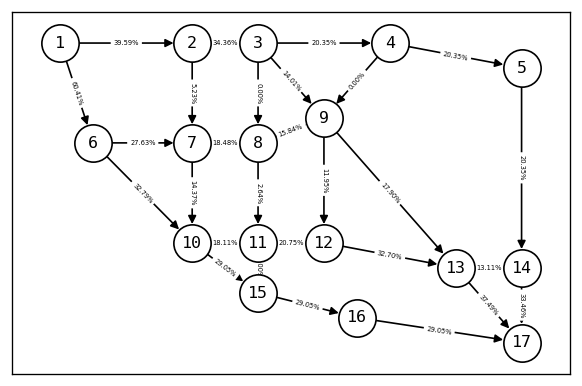

In [534]:
plt.figure(dpi = 120)
elab = dict(zip(edges, f_new.value*100/nu[0]))
elab = {k: f'{v:.2f}%' for k,v in elab.items()}
nx.draw_networkx(G3, pos, **options)
nx.draw_networkx_edge_labels(G3, pos, edge_labels=elab, font_color='black', font_size=4)
plt.savefig('plot3f_new_soc_optimum', dpi=120)
plt.show()

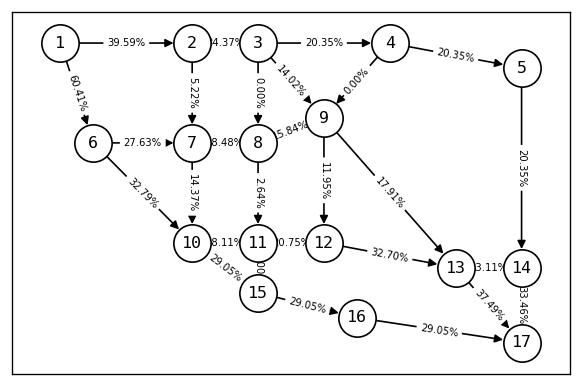

In [535]:
plt.figure(dpi = 120)
elab = dict(zip(edges, f_new_war.value*100/nu[0]))
elab = {k: f'{v:.2f}%' for k,v in elab.items()}
nx.draw_networkx(G3, pos, **options)
nx.draw_networkx_edge_labels(G3, pos, edge_labels=elab, font_color='black', font_size=6)
plt.savefig('plot3f_new_war_tolls', dpi=120)
plt.show()